In [88]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [89]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):    
    score_matrix = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index()
    
    best_match = score_matrix.loc[score_matrix.groupby("index")["value"].idxmax()].reset_index(drop=True)
    
    missing_gt = set(ground_truth.index) - set(best_match["variable"].unique())
    missing_gt = pd.DataFrame({"index": None, "variable": list(missing_gt), "value": 0})
    
    # TODO: fix case when there are multiple comedians
    return best_match.append(missing_gt).groupby("variable").mean().rename(columns={"value": "score"})
    
    # ground_truth["value"] = 0
    # ground_truth.loc[~ground_truth.index.isin(best_match["variable"]), "value"]
    
    # scores = model_answers.apply(
    #     lambda row_model: ground_truth.apply(
    #         lambda row_truth: 
    #             fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
    #             if row_model["comedian"] == row_truth["comedian"] 
    #             else None,
    #     axis=1),
    # axis=1) \
    #     .melt(ignore_index=False) \
    #     .dropna() \
    #     .reset_index() \
    #     .join(model_answers["sentence"], on="index") \
    #     .rename(columns={"sentence": "model"}) \
    #     .join(ground_truth, on="variable") \
    #     .rename(columns={"sentence": "truth", "value": "score"})
        
    # scores = scores[["comedian", "model", "truth", "score"]]
    # print("scores", scores)
    
    # df = scores.groupby(["comedian", "model"])[["score", "truth"]].max().reset_index()
    # print("df")
    # print(df)
    # truths = scores[~scores['truth'].isin(df['truth'])]
    # print("truths")
    # print(truths)
    
    # entries = truths.copy()
    # entries['score'] = 0
    # print("entries")
    # print(entries)
    # df = pd.concat([df, entries[['comedian', 'model', 'truth', 'score']]], ignore_index=True)
    # df.sort_values(by=['comedian', 'model'], inplace=True)
    # print("df")
    # print(df)
    
    # return df.groupby("truth")["score"].mean().reset_index()

In [90]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [91]:
#ground truth x ground truth
gt = bipartite_metric(ground_truth, ground_truth)
gt.mean()

score    100.0
dtype: float64

In [92]:
wrong = pd.DataFrame().reindex_like(ground_truth).drop(["laugh_start", "laugh_end"], axis=1)
wrong["comedian"] = ground_truth["comedian"]
wrong["sentence"] = ""
completely_wrong = bipartite_metric(wrong, ground_truth)
completely_wrong.mean()

score    0.0
dtype: float64

In [93]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

In [94]:
gemma_metric

,score
variable,
0,0.0
1,65.0
2,43.0
3,0.0
4,46.0
...,...
241,0.0
242,50.0
243,0.0


In [95]:
gemma_metric["score"].mean() 

24.5189701897019

In [96]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [97]:
brute_model = pd.DataFrame(brute_sentences)

In [98]:
brute = bipartite_metric(brute_model, ground_truth)

In [99]:
brute

,score
variable,
0,47.000000
1,51.750000
2,58.333333
3,97.000000
4,50.000000
...,...
241,95.000000
242,36.666667
243,45.800000


In [100]:
brute["score"].mean() 

58.142793058341844

In [101]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() 

25.26978319783198

In [102]:
random

,score
variable,
0,0.000000
1,0.000000
2,42.000000
3,42.000000
4,38.000000
...,...
241,0.000000
242,56.000000
243,0.000000


In [103]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [104]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

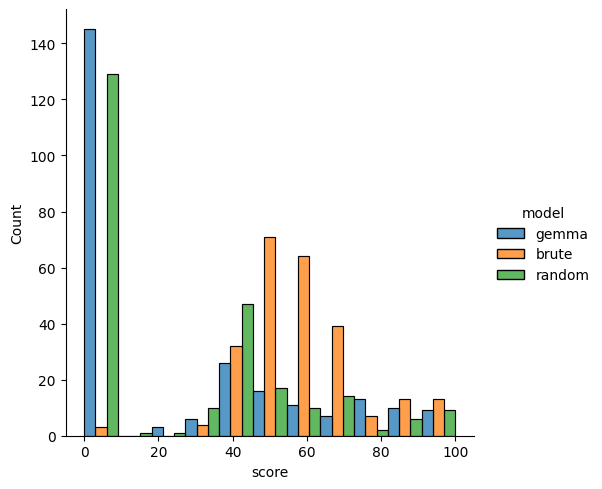

In [105]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [106]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() 

21.807588075880755

In [107]:
phi = phi_metric.assign(model="phi") 

In [108]:
llm = pd.concat([gemma, phi, brute, random]).reset_index(drop=True)

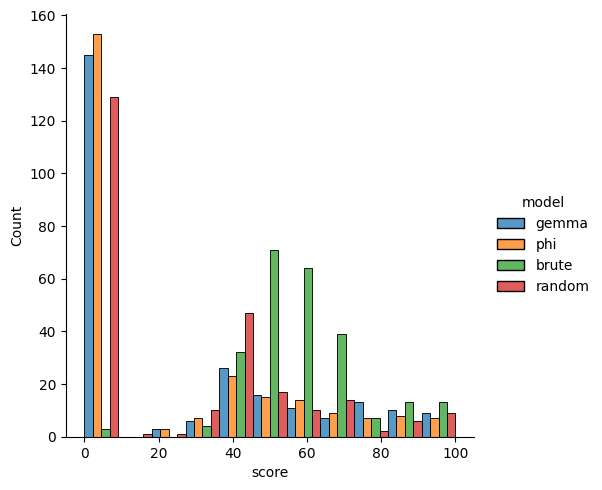

In [109]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

Chat_GPT

In [110]:
chatgpt_model = pd.read_csv("/home/ada/humor/data/Chat_GPT_results - Sheet1.csv")
chatgpt_model
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...
7,Russell_Peters,"He goes, look, you’re a 48-year-old Indian man..."
8,Russell_Peters,There is no way you can be Indian and not have...
9,Russell_Peters,There’s no way you can consume the food that w...


In [111]:
chatgpt_jm = chatgpt_model[chatgpt_model["comedian"] == "John_Mulaney"]
ground_truth_jm = ground_truth[ground_truth["comedian"]== "John_Mulaney"]
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

In [112]:
ground_truth_jm

,comedian,laugh_start,laugh_end,sentence
50,John_Mulaney,20.2350,22.6280,My wife and I just gave a bunch of stuff to Go...
51,John_Mulaney,30.5460,32.0200,"And then one day my wife said, ""Hey, you took ..."
52,John_Mulaney,44.3320,46.4850,"I was like, ""This one's shirts. I got a bunch ..."
53,John_Mulaney,59.4920,65.8650,"He's like, ""Take this receipt for the clothing..."
54,John_Mulaney,67.8500,70.7620,My mom said it could be a sleep shirt. Please ...
55,John_Mulaney,73.5270,74.2070,That sleep shirt bullshit.
56,John_Mulaney,83.9075,85.8990,"""Well, if it's too big you can just wear it as..."
57,John_Mulaney,97.7550,105.9800,"""Because we don't say that when someone gives ..."
58,John_Mulaney,113.7820,125.0765,So rather than violate these meaningless polit...


In [113]:
chatgpt_metric_jm = bipartite_metric(chatgpt_jm, ground_truth_jm)
print(chatgpt_metric_jm)

          score
variable       
50         42.0
51         68.0
52         57.0
53         43.0
54          0.0
55          0.0
56         42.0
57         43.0
58         56.5


In [114]:
chatgpt_metric_jm["score"].mean() 

39.05555555555556

In [115]:
model_jm = model[model["comedian"] == "John_Mulaney"]
model_jm = bipartite_metric(model_jm, ground_truth_jm)
model_jm["score"].mean() 

31.944444444444443

## Different Prompts

##### "The following is a stand-up comedy transcript. When performed in front of a live audience, which jokes do you think made the audience laugh?  List of quotes:"

In [117]:
laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/laugh_prompt - Sheet1.csv')

In [120]:
laugh_metric = bipartite_metric(laugh, ground_truth)
laugh_metric

,score
variable,
0,0.0
1,88.0
2,43.0
3,0.0
4,31.0
...,...
241,0.0
242,49.0
243,35.0


In [121]:
laugh_metric.mean()

score    24.281165
dtype: float64

#### The following is a stand-up comedy transcript. What are the funniest punchlines from the transcript. List of quotes:"

In [122]:
punchline = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/punchline_prompt - Sheet1.csv')

In [123]:
punchline_metric = bipartite_metric(punchline, ground_truth)
punchline_metric

,score
variable,
0,0.0
1,16.0
2,0.0
3,39.0
4,0.0
...,...
241,55.0
242,49.0
243,0.0


In [124]:
punchline_metric.mean()

score    25.096206
dtype: float64

#### Below is a transcript from a stand-up comedy routine. Analyze the transcript and extract the quotes that are most likely to have made the audience laugh. List of quotes:

In [125]:
most_laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/mostlaugh_prompt - Sheet1.csv')

In [126]:
most_laugh_metric = bipartite_metric(most_laugh, ground_truth)
most_laugh_metric

,score
variable,
0,0.0
1,16.0
2,0.0
3,39.0
4,0.0
...,...
241,55.0
242,51.0
243,0.0


In [127]:
most_laugh_metric.mean()

score    23.647019
dtype: float64

In [130]:
laugh = laugh_metric.assign(model="laugh") 
punchline = punchline_metric.assign(model="punchline")
most_laugh = most_laugh_metric.assign(model="most_laugh")

In [131]:
df = pd.concat([gemma, laugh, punchline, most_laugh]).reset_index(drop=True)

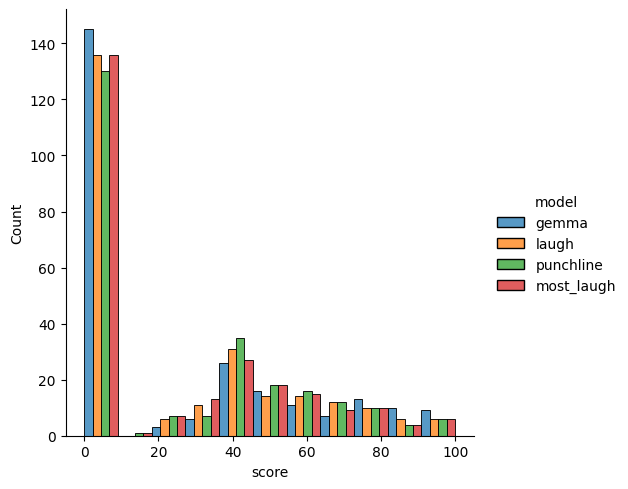

In [134]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [140]:
llm_gt = ground_truth.loc[ground_truth["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters"])]

In [142]:
chatgpt = pd.read_csv("/home/ada/humor/data/Chat_GPT_results - Sheet1.csv")

In [145]:
chatgpt_metric = bipartite_metric(chatgpt, llm_gt)
chatgpt_metric

,score
variable,
50,42.00
51,68.00
52,57.00
53,43.00
54,0.00
55,0.00
56,42.00
57,43.00
58,56.50


In [146]:
chatgpt_metric.mean()

score    36.440476
dtype: float64

In [147]:
claude = pd.read_csv("/home/ada/humor/data/Claude_results - Sheet1.csv")

In [148]:
claude_metric = bipartite_metric(claude, llm_gt)
claude_metric

,score
variable,
50,42.0
51,73.0
52,0.0
53,0.0
54,0.0
55,0.0
56,41.0
57,43.0
58,100.0


In [149]:
claude_metric.mean()

score    32.166667
dtype: float64

In [155]:
gemma_llm = model.loc[model["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters"])]

In [159]:
gemma_llm_metric = bipartite_metric(gemma_llm, llm_gt)
gemma_llm_metric.mean()

score    30.404762
dtype: float64

In [160]:
gemma = gemma_llm_metric.assign(model = "gemma")
claude = claude_metric.assign(model="claude") 
chatgpt = chatgpt_metric.assign(model="chatgpt")

In [161]:
df = pd.concat([gemma, claude, chatgpt]).reset_index(drop=True)

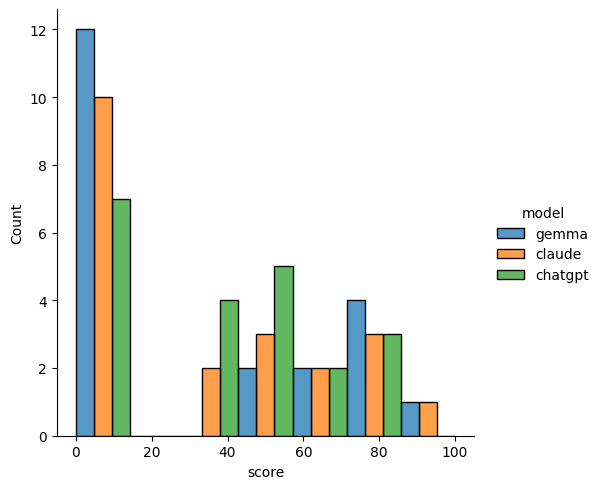

In [162]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")